# Creating base dataset

Here will be paths and binding affinity

In [1]:
import os
import re

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

## Dataset from index (general, refined) files

In [2]:
dataPath = './data/2020/index'

generalFile = "INDEX_general_PL.2020"
refinedFile = "INDEX_refined_data.2020"

generalFullPath = os.path.join(dataPath, generalFile)
refinedFullPath = os.path.join(dataPath, refinedFile)

df_columns = ['pdbcode', 'year', 'set', 'affinity']

In [3]:
def getPDBbind(fileFullPath, columnNames, setName=None):
    
    """
    Funtion to convert PDBbind textfile to a dataframe:
    
    Parameters:
        fileFullPath (string): location of textfile 
        setName(string): set from PDBbind (general, refined, or core)
        columnNames(list): list of features to include in dataframe
    Return:
        df: Dataframe object with columns 'pdbCodes', 'year', 'realAffinity'
    """
    
    pdbCodes = []
    year = []
    realAffinity = []
    
    df = pd.DataFrame(columns=columnNames)
    
    if (os.path.isfile(fileFullPath)):    #check if path exists 
        print ("Processing File: %s. \n" % fileFullPath )

        with open (fileFullPath, 'rt') as pdbbindSet:
            for line in pdbbindSet:
                if not line.startswith("#"):
                    columns = line.split()
                    pdbCodes.append(columns[0])
                    year.append(columns[2])
                    realAffinity.append(columns[3])        
    else:
        raise(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), refinedFullPath))


    df["pdbcode"] = pdbCodes
    df["year"] = year
    df["affinity"] = realAffinity
    df["set"] = setName
    
    print (df.head())
    
    print ("\nTotal Complexes in %s Set: %6d \n" % (setName, df.shape[0]) )
    
    return (df)

In [4]:
def mergePDBbind(df1, df2, df1_set, df2_set, columnNames ):
    """
    Merge Dataframes and label merger DataFrame. df2 is a subset of df1
    
    Parameters:
        df1 (pandas DataFrame): one of two dataframes requiring merging
        df2 (pandas DataFrame): second of two dataframes requiring merging
        df1_set (string): label of first dataframe
        df2_set (string): label of second dataframe
    Return:
        df1: Merged df1 with df2 and labelled with df1_set, df2_set.
    """
    
    # Confirm all refined set is in general, and that there are no extra pdbCodes outside general set

    # check df1, df2 types
    
    # Use list l to merge dataframes
    l = ["pdbcode", "year", "affinity"]

    # merge refined with df1
    df1 = df1.merge(df2, on=l, indicator=True, how='outer')
    merged = df1.groupby('_merge').count() #merge is a df provideing counts. _merge column is created.
    #print (df1.head())

    # List pdbCodes that ARE NOT in refined set (left_only) after merging
    G = merged.loc['left_only', 'pdbcode']

    # List pdbCodes that ARE in refined set and general set (left_only) after merging
    R = merged.loc['both', 'pdbcode']

    # List pdbCodes that ARE ONLY in refined set (right_only) after merging
    R_only = merged.loc['right_only', 'pdbcode']
    
    #df1['split'] = df1['split_x']

    if (R_only != 0):
        #print  ("Found %d pdbCodes from 'Refined Set' that are not in 'General Set' " % R_only)
        raise ValueError ("Found %d pdbCodes from 'Refined Set' that are not in 'General Set' " % R_only)

    if (df2['pdbcode'].count() == R):
        print ("All refined set is in general set.\n")

        #label df1 pdbcodes as refined
        df1['set'] = df1['_merge'].apply(lambda x: df2_set if x == 'both' else df1_set) 
        #print (df1.head())

        # Drop Extra Columns
        # Get list of extra columns created. Negate Intersection (union - intersection)
        dropColumns = list((set(df1.columns).union(set(columnNames))) - set(df1.columns).intersection(set(columnNames)))
        df1 = df1.drop(columns=dropColumns)
        print (df1.head())
        
    return (df1)

In [5]:
df_general = getPDBbind(generalFullPath, df_columns, setName = 'general')

Processing File: ./data/2020/index\INDEX_general_PL.2020. 

  pdbcode  year      set   affinity
0    2tpi  1982  general    Kd=49uM
1    5tln  1982  general  Ki=0.43uM
2    4tln  1982  general   Ki=190uM
3    4cts  1984  general    Kd<10uM
4    6rsa  1986  general    Ki=40uM

Total Complexes in general Set:  19443 



In [6]:
df_general

,pdbcode,year,set,affinity
0,2tpi,1982,general,Kd=49uM
1,5tln,1982,general,Ki=0.43uM
2,4tln,1982,general,Ki=190uM
3,4cts,1984,general,Kd<10uM
4,6rsa,1986,general,Ki=40uM
...,...,...,...,...
19438,6gxe,2019,general,Ki=9nM
19439,6r0u,2019,general,Ki>40uM
19440,6r0s,2019,general,Ki>40uM
19441,6r12,2019,general,Ki>40uM


In [16]:
df_refined = getPDBbind(refinedFullPath, df_columns, setName = 'refined')

Processing File: ./data/2020/index\INDEX_refined_data.2020. 

  pdbcode  year      set affinity
0    2r58  2007  refined     2.00
1    3c2f  2008  refined     2.00
2    3g2y  2009  refined     2.00
3    3pce  1998  refined     2.00
4    4qsu  2014  refined     2.00

Total Complexes in refined Set:   5316 



In [21]:
df_pdb = mergePDBbind(df_general, df_refined, 'general', 'refined', df_columns)
df_pdb.groupby('set').count()

All refined set is in general set.

  pdbcode  year affinity      set
0    3zzf  2012     0.40  general
1    3gww  2009     0.45  general
2    1w8l  2004     0.49  general
3    3fqa  2009     0.49  general
4    1zsb  1996     0.60  general


,pdbcode,year,affinity
set,,,
general,14127,14127,14127
refined,5316,5316,5316


In [22]:
df_pdb.head()

,pdbcode,year,affinity,set
0,3zzf,2012,0.40,general
1,3gww,2009,0.45,general
2,1w8l,2004,0.49,general
3,3fqa,2009,0.49,general
4,1zsb,1996,0.60,general


In [23]:
df_pdb.isna().sum()

pdbcode     0
year        0
affinity    0
set         0
dtype: int64

In [24]:
df_pdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19443 entries, 0 to 19442
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pdbcode   19443 non-null  object
 1   year      19443 non-null  object
 2   affinity  19443 non-null  object
 3   set       19443 non-null  object
dtypes: object(4)
memory usage: 759.5+ KB


## Adding pathes to df

In [29]:
startPath = './data/2020/sets/'

maxLevel = 0
pdbCodeFolders = []
pdbCodePaths  = []
setFolders = []
split = []

for subdirFullPath, dirs, files in os.walk(startPath):
    level = subdirFullPath.replace(startPath, '').count(os.sep)
    if level > maxLevel:
        maxLevel = level
        
maxLevel = maxLevel + 1

if (maxLevel > 2):
    raise ValueError ("Expected 2 subdirectory (refined, general) in dataset path. Got %d !" % (maxLevel))
else:
    print ("Found %d Directory Levels" % maxLevel)
    
setFolders = []    

for subdirFullPath, dirs, files in os.walk(startPath):
    level = subdirFullPath.replace(startPath, '').count(os.sep)
    if subdirFullPath == startPath:
        next
    elif level == 0:
        setFolders.append (subdirFullPath.replace(startPath, ''))
        print (subdirFullPath)
    elif level == 1:   
        pdbCodePaths.append (subdirFullPath)
        pdbCodeFolders.append (subdirFullPath[-4:])
        if (re.search( "refined-set", subdirFullPath)):
            split.append ( 'refined' )
        elif (re.search( "general-set", subdirFullPath)):
            split.append ( 'general' )
        #pdbCodeFolders.append (subdirFullPath.replace(os.path.join(startPath, setFolders[level-1]), ''))

print ("\nFound %d pdbCode Folders." % len(pdbCodeFolders)) 

Found 2 Directory Levels
./data/2020/sets/general-set
./data/2020/sets/refined-set

Found 19443 pdbCode Folders.


In [40]:
# create dataset
columnNames = ["pdbcode", "path", "is4files"]

df_path = pd.DataFrame(columns=columnNames)
df_path['pdbcode']  = pdbCodeFolders
df_path['path']  = pdbCodePaths

df_path.tail()

,pdbcode,path,is4files
19438,7std,./data/2020/sets/refined-set\7std,NaN
19439,7upj,./data/2020/sets/refined-set\7upj,NaN
19440,8a3h,./data/2020/sets/refined-set\8a3h,NaN
19441,8cpa,./data/2020/sets/refined-set\8cpa,NaN
19442,966c,./data/2020/sets/refined-set\966c,NaN


In [42]:
# Check if each of the protein folders contains 4 files.
# Names of the files are not checked.

i=0
include = []

for path in df_path['path']:
    files = os.listdir(path) #list contect of directory, returns list of all files
    file_count = 0
    for file in files:
        if (os.path.isfile(os.path.join(path, file))):
            file_count += 1
    if not ( len(files) == 4 or len(files) == 5 ):
        print ("Files in path %s Not Found.\n %d Files Found." % (path, len(files)))
        print ("Verify Files at %s.\n" % path)
        include.append(False)
    else:
        include.append(True)
        i += 1
        
print ("%d out of %d files found.\n" % (i, len(df_path['path'])))
df_path['is4files'] = include

19443 out of 19443 files found.



In [43]:
df_path.is4files.unique()

array([ True])

## Creating final df

In [44]:
df_final = df_pdb.merge(df_path, on=['pdbcode'], indicator=True, how='outer')
df_final.head()

,pdbcode,year,affinity,set,path,is4files,_merge
0,3zzf,2012,0.40,general,./data/2020/sets/general-set\3zzf,True,both
1,3gww,2009,0.45,general,./data/2020/sets/general-set\3gww,True,both
2,1w8l,2004,0.49,general,./data/2020/sets/general-set\1w8l,True,both
3,3fqa,2009,0.49,general,./data/2020/sets/general-set\3fqa,True,both
4,1zsb,1996,0.60,general,./data/2020/sets/general-set\1zsb,True,both


In [45]:
df_final.isna().sum()

pdbcode     0
year        0
affinity    0
set         0
path        0
is4files    0
_merge      0
dtype: int64

In [46]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19443 entries, 0 to 19442
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pdbcode   19443 non-null  object  
 1   year      19443 non-null  object  
 2   affinity  19443 non-null  object  
 3   set       19443 non-null  object  
 4   path      19443 non-null  object  
 5   is4files  19443 non-null  bool    
 6   _merge    19443 non-null  category
dtypes: bool(1), category(1), object(5)
memory usage: 949.5+ KB


In [47]:
df_final['affinity'] = [(lambda x: float(x))(x) for x in df_final['affinity']]
df_final['year'] = [(lambda x: int(x))(x) for x in df_final['year']]
df_final['path'] = [(lambda x: x.replace("\\", "/"))(x) for x in df_final['path']]

In [58]:
df_final.drop(columns = ['is4files', '_merge'], inplace = True)

In [67]:
tail_ligand_mol2 = '_ligand.mol2'
tail_ligand_std = '_ligand.std'
tail_protein_pdb = '_protein.pdb'
tail_pocket_pdb = '_pocket.pdb'

df_final['ligand_mol2'] = df_final.path.apply(lambda x: x + '/' + x.split('/')[-1] + tail_ligand_mol2)
df_final['ligand_std'] = df_final.path.apply(lambda x: x + '/' + x.split('/')[-1] + tail_ligand_std)
df_final['protein_pdb'] = df_final.path.apply(lambda x: x + '/' + x.split('/')[-1] + tail_protein_pdb)
df_final['pocket_pdb'] = df_final.path.apply(lambda x: x + '/' + x.split('/')[-1] + tail_pocket_pdb)

In [68]:
df_final.head()

,pdbcode,year,affinity,set,path,ligand_mol2,ligand_std,protein_pdb,pocket_pdb
0,3zzf,2012,0.40,general,./data/2020/sets/general-set/3zzf,./data/2020/sets/general-set/3zzf/3zzf_ligand....,./data/2020/sets/general-set/3zzf/3zzf_ligand.std,./data/2020/sets/general-set/3zzf/3zzf_protein...,./data/2020/sets/general-set/3zzf/3zzf_pocket.pdb
1,3gww,2009,0.45,general,./data/2020/sets/general-set/3gww,./data/2020/sets/general-set/3gww/3gww_ligand....,./data/2020/sets/general-set/3gww/3gww_ligand.std,./data/2020/sets/general-set/3gww/3gww_protein...,./data/2020/sets/general-set/3gww/3gww_pocket.pdb
2,1w8l,2004,0.49,general,./data/2020/sets/general-set/1w8l,./data/2020/sets/general-set/1w8l/1w8l_ligand....,./data/2020/sets/general-set/1w8l/1w8l_ligand.std,./data/2020/sets/general-set/1w8l/1w8l_protein...,./data/2020/sets/general-set/1w8l/1w8l_pocket.pdb
3,3fqa,2009,0.49,general,./data/2020/sets/general-set/3fqa,./data/2020/sets/general-set/3fqa/3fqa_ligand....,./data/2020/sets/general-set/3fqa/3fqa_ligand.std,./data/2020/sets/general-set/3fqa/3fqa_protein...,./data/2020/sets/general-set/3fqa/3fqa_pocket.pdb
4,1zsb,1996,0.60,general,./data/2020/sets/general-set/1zsb,./data/2020/sets/general-set/1zsb/1zsb_ligand....,./data/2020/sets/general-set/1zsb/1zsb_ligand.std,./data/2020/sets/general-set/1zsb/1zsb_protein...,./data/2020/sets/general-set/1zsb/1zsb_pocket.pdb


In [70]:
df_final.to_csv('./data/2020/base_df.csv')

In [2]:
df_columns = ['pdbcode', 'year', 'set', 'affinity']

general_path = './data/2016/'

In [10]:
mol = Chem.MolFromPDBFile('data/2020/sets/general-set/11gs/11gs_pocket.pdb')

In [11]:
smi = Chem.MolToSmiles(mol)
smi

'CC(C)C[C@@H](C=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](N)CCC(=O)O.CC(C)C[C@H](N)C(=O)N[C@H](C=O)CCCC[NH3+].CC(C)C[C@H](N)C=O.CC(C)C[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)N1CCC[C@H]1C(=O)N[C@H](C=O)CCCC[NH3+].CC(C)[C@H](N)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C=O)CCC(=O)O)C(C)C)[C@@H](C)O.CC(C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(N)=[NH2+])C(=O)NCC(=O)N[C@@H](CCCNC(N)=[NH2+])C(=O)N[C@@H](CS)C(=O)N[C@@H](C)C=O.CC[C@H](C)[C@H](N)C(=O)N[C@H](C=O)Cc1ccc(O)cc1.CC[C@H](C)[C@H](N)C=O.CC[C@H](C)[C@H](NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)N[C@H](C=O)CO.CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](N)Cc1ccc(O)cc1)[C@@H](C)O)C(=O)N[C@H](C=O)CC(C)C.CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1)C(=O)N[C@@H](CC(N)=O)C(=O)NCC(=O)N[C@@H](CC(N)=O)C(=O)NCC=O.CSCC[C@H](N)C=O.NC(=O)CC[C@@H](C=O)NC(=O)[C@@H](N)Cc1c[nH]c2ccccc12.NC(=[NH2+])NCCC[C@H](N)C(=O)N[C@H](C=O)CS.NCC=O.N[C@@H](CC(=O)O)C(=O)

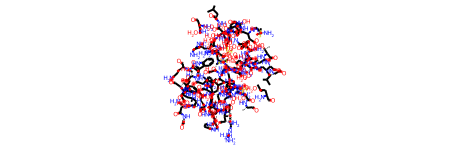

In [13]:
mol

In [14]:
mol_block = Chem.MolToMolBlock(mol)
print(mol_block)

11GS_POCKET
     RDKit          3D

466434  0  0  0  0  0  0  0  0999 V2000
   15.8650    2.4260   34.0850 N   0  0  0  0  0  0  0  0  0  0  0  0
   14.8710    2.2990   33.0410 C   0  0  2  0  0  0  0  0  0  0  0  0
   13.7480    1.3910   33.5120 C   0  0  0  0  0  0  0  0  0  0  0  0
   13.7590    0.8950   34.6470 O   0  0  0  0  0  0  0  0  0  0  0  0
   15.5600    1.6730   31.8280 C   0  0  0  0  0  0  0  0  0  0  0  0
   14.8220    1.7870   30.5260 C   0  0  0  0  0  0  0  0  0  0  0  0
   14.4960    3.0260   29.9890 C   0  0  0  0  0  0  0  0  0  0  0  0
   14.5300    0.6500   29.7750 C   0  0  0  0  0  0  0  0  0  0  0  0
   13.9070    3.1330   28.7380 C   0  0  0  0  0  0  0  0  0  0  0  0
   13.9420    0.7450   28.5260 C   0  0  0  0  0  0  0  0  0  0  0  0
   13.6340    1.9930   28.0100 C   0  0  0  0  0  0  0  0  0  0  0  0
   13.0360    2.0910   26.7690 O   0  0  0  0  0  0  0  0  0  0  0  0
   12.7560    1.2340   32.6410 N   0  0  0  0  0  0  0  0  0  0  0  0
   11.6200    

In [15]:
fp1 = AllChem.GetMorganFingerprint(mol,2)
fp1

In [16]:
fp2 = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048)
fp2

In [17]:
fp = fp2.ToList()
len(fp)

2048